<h1><center><font color = 'blue'>AMSUA N18 CH7 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from scipy import stats

In [2]:
!conda install -c conda-forge -y keras lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.9

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - keras
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    grpcio-1.12.1              |   py36hdbcaa40_0         1.7 MB
    astor-0.7.1                |             py_0          22 KB  conda-forge
    lightgbm-2.1.2             |   py36hfc679d8_0         705 KB  conda-forge
    pygpu-0.7.6                |           py36_0         1.4 MB  conda-forge
    absl-py-0.3.0              |             py_0          76 KB  conda-forge
    opencv-3.3.1               |   py36h0a11808_0        38.9 MB
    termcolor-1.1.0            |             py_2           6 KB  conda-forge
 

In [3]:
!conda install -y basemap

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.9

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - basemap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-1.13.3               |   py36hdbf6ddf_4         3.9 MB
    openssl-1.0.2o             |       h14c3975_1         3.4 MB
    basemap-1.0.7              |      np113py36_0       118.9 MB
    geos-3.5.0                 |                0        16.9 MB
    ------------------------------------------------------------
                                           Total:       143.2 MB

The following NEW packages will be INSTALLED:

    basemap:         1.0.7-np113py36_0                
    geos:            3.5.0-0             

In [4]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import psutil
import boto3
import time
import sys
import os

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense

from scipy import stats
from math import trunc

sys.path.append("lib")

import lib_mapping as lmapping
import lib_obimpact as loi
import lib_utils as lutils

Using TensorFlow backend.


Pandas consume a lot of RAM when dealing with large dataset, so let's define a function to keep an eye on how much we are using.

In [5]:
def print_ram_usage():
    process = psutil.Process(os.getpid())
    ram_usage = round(process.memory_info().rss/float(2**30), 2)
    print("RAM usage: {}GB".format(ram_usage))

### Import data

In [6]:
start = time.time()

resource = boto3.resource("s3")

s3_filepath = "ml_data/amsua_n18_ch7.h5"
nb_filepath = "/tmp/" + s3_filepath.split("/")[-1]

resource.Bucket("fsoi").download_file(s3_filepath, nb_filepath)
df = pd.read_hdf(nb_filepath)
os.remove(nb_filepath)

end = time.time()
print("Data imported in: {} min and {} sec".format(trunc((end - start)/60),
                                                   round((end - start)%60)))

print_ram_usage()

Data imported in: 3 min and 54 sec
RAM usage: 9.81GB


### Compute sensitivity, and hour feature

In [7]:
df["SENSITIVITY"] = df["IMPACT"]/df["OMF"]
df["hour"] = df["DATETIME"].dt.hour

In [8]:
df.tail()

,DATETIME,IMPACT,LATITUDE,LONGITUDE,OMF,delp_0.015,delp_0.026,delp_0.04,delp_0.057,delp_0.078,...,v_873.975,v_888.632,v_903.289,v_917.946,v_932.602,v_947.258,v_961.913,v_976.62,SENSITIVITY,hour
4199834,2015-02-28 18:00:00,-0.000004,88.250000,-96.519997,0.329822,1.0,1.27,1.488501,1.8415,2.3345,...,-0.010676,0.593499,1.136518,1.505242,1.942371,2.311975,2.691252,2.824533,-0.000011,18
4199835,2015-02-28 18:00:00,-0.000165,88.419998,111.849998,0.196722,1.0,1.27,1.488501,1.8415,2.3345,...,-4.826113,-4.162806,-3.729328,-3.426113,-2.980954,-2.648366,-2.550055,-2.323054,-0.000839,18
4199836,2015-02-28 18:00:00,-0.000078,89.189995,-171.569992,0.156673,1.0,1.27,1.488501,1.8415,2.3345,...,-4.714759,-5.147550,-5.511382,-5.582294,-6.103623,-6.217340,-5.986819,-5.482580,-0.000495,18
4199837,2015-02-28 18:00:00,-0.000063,89.269997,46.529999,0.084857,1.0,1.27,1.488501,1.8415,2.3345,...,5.708429,5.440742,5.119752,4.757587,4.508724,4.032255,3.689447,3.532344,-0.000743,18
4199838,2015-02-28 18:00:00,-0.000064,89.320000,-62.049999,0.129242,1.0,1.27,1.488501,1.8415,2.3345,...,2.841720,2.137918,1.564459,1.395590,2.000310,2.625103,2.801180,2.766160,-0.000496,18


### Remove outliers

In [9]:
mean = df["SENSITIVITY"].mean()
std = df["SENSITIVITY"].std()

df = df[(df["SENSITIVITY"] > mean - 3*std) & (df["SENSITIVITY"] < mean + 3*std)]

df.reset_index(drop=True, inplace=True)

### Split train and test samples by datetime

We will train on the eleven first weeks, then test on the last two weeks.

In [10]:
df = df.set_index(["DATETIME"])

train = df.loc["2014-12-01 00:00:00": "2015-02-14 18:00:00"].reset_index()
test = df.loc["2015-02-15 00:00:00": "2015-02-28 18:00:00"].reset_index()

print_ram_usage()

RAM usage: 28.36GB


### Split inputs and outputs

In [11]:
X_train = train.drop(["DATETIME", "IMPACT", "OMF", "SENSITIVITY"], axis=1)
X_test = test.drop(["DATETIME", "IMPACT", "OMF", "SENSITIVITY"], axis=1)

y_train = train["SENSITIVITY"]
y_test = test["SENSITIVITY"]

cols = X_train.columns.tolist()

print_ram_usage()

RAM usage: 37.49GB


### Standardize data to zero mean and unit variance

If a predictor has a larger magnitude than others, it will lead to more change caused by this predictor for the weights of the Neural Network when updating them through gradient backpropagation.
Practice has shown that this step often leads to more efficient training. As our target has a very small order of magnitude, it will also help us to interpret the results with more readability.

In [12]:
X_scaler, y_scaler = StandardScaler(), StandardScaler()

X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=cols)

y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1, )
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).reshape(-1, )

In [13]:
print_ram_usage()

RAM usage: 46.52GB


### Explore y (Sensitivity)

In [14]:
pd.Series(y_train).describe()

count    3.467110e+06
mean     7.325363e-17
std      1.000000e+00
min     -4.113671e+00
25%     -4.063007e-01
50%     -5.181761e-03
75%      4.044049e-01
max      4.113908e+00
dtype: float64

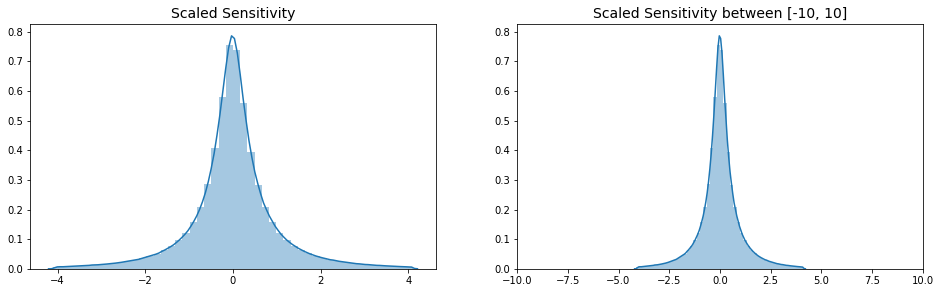

Shapiro test:
Statistics = 0.9392, p-value = 0.0
P-value < 0.05, sample does not look Gaussian (reject H0)


In [15]:
# plot Sensitivity
fig, axs = plt.subplots(1, 2, figsize=(16, 4.5))

sns.distplot(y_train, ax=axs[0])
sns.distplot(y_train, ax=axs[1])

axs[0].set_title("Scaled Sensitivity", fontdict={"size": 14})
axs[1].set_title("Scaled Sensitivity between [-10, 10]", fontdict={"size": 14})

axs[1].set_xlim([-10, 10])

plt.show()

# test Sensitivity normality
stat, p = stats.shapiro(y_train)
print("Shapiro test:")
print("Statistics = {:.4}, p-value = {:.4}".format(stat, p))

alpha = 0.05
if p > alpha:
    print("P-value > {}, sample looks Gaussian (fail to reject H0)".format(alpha))
else:
    print("P-value < {}, sample does not look Gaussian (reject H0)".format(alpha))

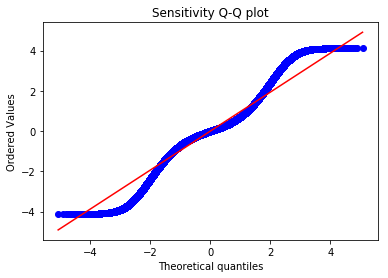

Kurtosis measure: 2.882


In [16]:
# display Q-Q plot
res = stats.probplot(y_train, plot=plt)
plt.title("Sensitivity Q-Q plot")
plt.show()

# print kurtosis measure
print("Kurtosis measure: {:.4}".format(stats.kurtosis(y_train)))

We notice that the distribution of Sensitivity has heavy tails. There are more extreme values than would be expected if data truly came from a normal distribution. Kurtosis value is very high, it confirms the presence of outliers.

### y correlations with X variables 

In [17]:
y_corr = X_train.corrwith(pd.Series(y_train), axis=0)

print("\n5 largest corr with y:\n{}".format(y_corr.nlargest()))
print("\n5 smallest corr with y:\n{}".format(y_corr.nsmallest()))

corr_cols = y_corr.nlargest().index.tolist() + y_corr.nsmallest().index.tolist()


5 largest corr with y:
sphu_265.745     0.015848
qitot_265.745    0.015820
qitot_226.234    0.014899
sphu_311.373     0.014728
sphu_226.234     0.014329
dtype: float64

5 smallest corr with y:
frland          -0.013543
hs_stdv         -0.011585
qitot_427.673   -0.010920
qitot_464.421   -0.010200
u_0.105         -0.009281
dtype: float64


We can notice that the correlations are really weak or even non-existent (very close to zero).

### Train and predict (Linear Regression / Neural Network / Gradient Boosting)

In [18]:
# train Linear Regression with the 5 most positive and
# 5 most negative correlated features
lr = LinearRegression()
lr.fit(X_train[corr_cols], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
# define and train Neural Network
def dense_nn():
    
    model = Sequential()
     
    model.add(Dense(64, input_dim=590))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
      
    model.add(Dense(1))
    
    model.compile(loss="mean_squared_error", optimizer="adam")
    
    return model


nn = KerasRegressor(build_fn=dense_nn, epochs=1, batch_size=512, verbose=1)

# fix random seed for reproducibility
np.random.seed(7)

nn.fit(X_train, y_train)

Epoch 1/1
3467110/3467110 [==============================] - 201s 58us/step - loss: 1.0134


In [20]:
# train Gradient Boosting
gbm = lgbm.LGBMRegressor(objective="regression", n_estimators=300, learning_rate=0.1, random_state=10)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=("train", "test"),
    eval_metric="l2",
    early_stopping_rounds=20,
    feature_name=cols,
    verbose=False
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=10,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

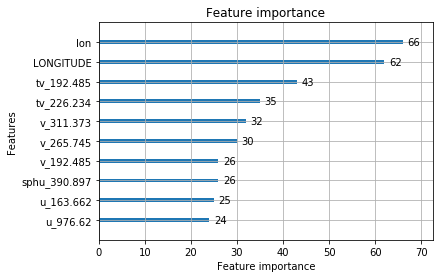

In [21]:
# take a look at Gradient Boosting feature importance by split
ax = lgbm.plot_importance(gbm, max_num_features=10, importance_type="split")
plt.show()

In [22]:
# predict LR
lr_pred = lr.predict(X_test[corr_cols])

In [23]:
# predict NN
nn_pred = nn.predict(X_test)

653503/653503 [==============================] - 4s 6us/step


In [24]:
# predict GBM
gbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

In [25]:
print_ram_usage()

RAM usage: 49.6GB


### Results

#### Mean Squared Errors / Mean Absolute Errors

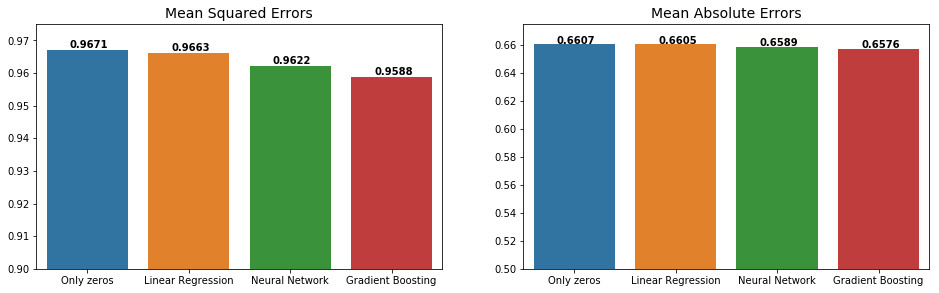

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4.5))

preds = [[0]*len(y_test), lr_pred, nn_pred, gbm_pred]

data_mse = [round(mean_squared_error(y_test, y_hat), 4) for y_hat in preds]
data_mae = [round(mean_absolute_error(y_test, y_hat), 4) for y_hat in preds]

labels = ["Only zeros", "Linear Regression", "Neural Network", "Gradient Boosting"]

sns.barplot(x=labels, y=data_mse, ax=axs[0])
sns.barplot(x=labels, y=data_mae, ax=axs[1])

axs[0].set_title("Mean Squared Errors", fontdict={"size": 14})
axs[1].set_title("Mean Absolute Errors", fontdict={"size": 14})

axs[0].set_ylim([0.90, 0.975])
axs[1].set_ylim([0.50, 0.675])

# display values on top of each bar
for ax, data in zip(axs, [data_mse, data_mae]):
    for ix, value in enumerate(data):
        x = ix - 0.17
        y = value + value*5e-4
        ax.text(x, y, str(value), fontdict={"weight": "bold"})

plt.show()

#### Linear Regression

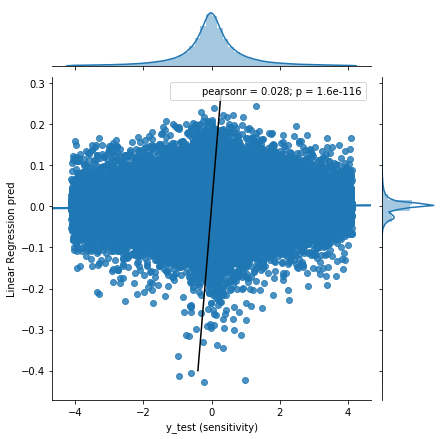

In [27]:
ax = sns.jointplot(x=y_test, y=lr_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel="y_test (sensitivity)", ylabel="Linear Regression pred")
# add bisector (in black)
plt.plot([-0.4, 0.28], [-0.4, 0.28], 'k-')
plt.show()

The predictions's range is really short [-0.4, 0.3] compared to real values's [-60, 40]. We can conclude that during training no linear pattern had been found in data for outliers. Finally, the Linear Regression just predict values close to zero without learning much.

#### Neural Network

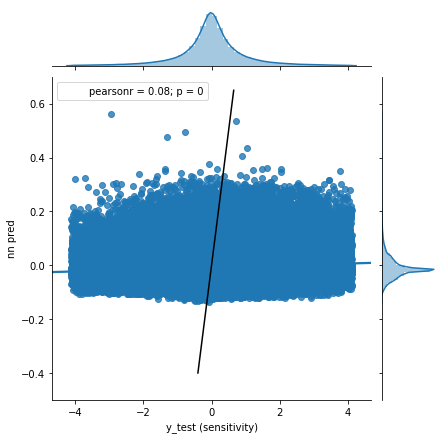

In [28]:
ax = sns.jointplot(x=y_test, y=nn_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel="y_test (sensitivity)", ylabel="nn pred")
# fix y axis limits
ax.ax_marg_y.set_ylim(-0.5, 0.7)
# add bisector (in black)
plt.plot([-0.4, 0.65], [-0.4, 0.65], "k-")
plt.show()

The predictions's range has a similar magnitude [-0.3, 0.6] with the LR. Same problem with outliers, no nonlinear pattern had been found during training.

#### Gradient Boosting

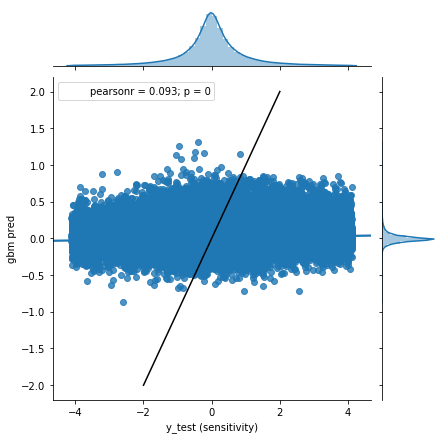

In [29]:
ax = sns.jointplot(x=y_test, y=gbm_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel="y_test (sensitivity)", ylabel="gbm pred")
# add bisector (in black)
plt.plot([-2, 2], [-2, 2], "k-")
plt.show()

The predictions's range is a bit better [-2, 2] than LR & NN. But our prediction power is still small, it just beats narrowly a naive prediction with only zeros.

#### Compute statistics about real sensitivity and pred sensitivity ratio

In [30]:
ratio = pd.Series(y_test/gbm_pred)
ratio.describe()

count    6.535030e+05
mean     5.139438e+01
std      4.955886e+04
min     -8.292482e+06
25%     -1.132127e+01
50%      9.978905e-01
75%      1.397143e+01
max      3.887636e+07
dtype: float64

#### Display ratio pdf

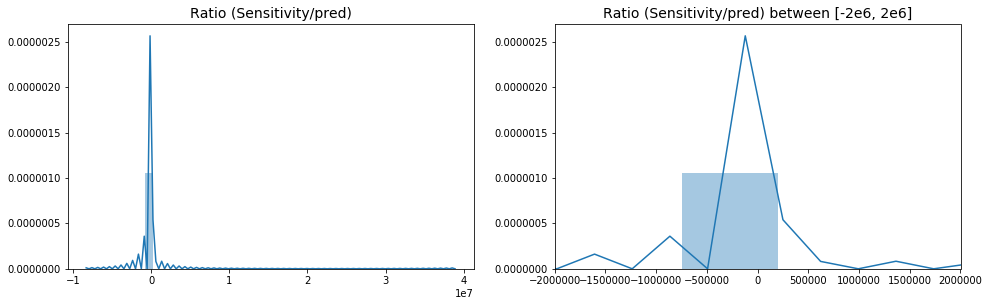

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4.5))

sns.distplot(ratio, norm_hist=True, ax=axs[0])
sns.distplot(ratio, norm_hist=True, ax=axs[1])

axs[0].set_title("Ratio (Sensitivity/pred)", fontdict={"size": 14})
axs[1].set_title("Ratio (Sensitivity/pred) between [-2e6, 2e6]", fontdict={"size": 14})

axs[1].set_xlim([-2e6, 2e6])

plt.show()

#### % of ratio values between ]-5:5[

In [32]:
print("{0:.2f}%".format(len(ratio[(ratio > -5) & (ratio < 5)])/len(ratio)*100))

27.64%


#### Display ratio pdf between ]-5:5[ 

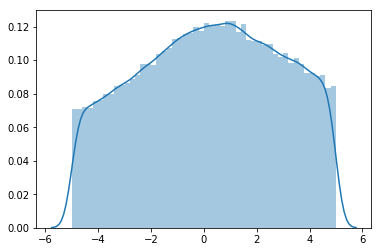

In [33]:
filtered = ratio[(ratio > -5) & (ratio < 5)]
ax = sns.distplot(filtered)

#### % of ratio values between ]0.5:1.5[

In [34]:
print("{0:.2f}%".format(len(ratio[(ratio > 0.5) & (ratio < 1.5)])/len(ratio)*100))

3.35%


#### % of ratio positive sign

In [35]:
print("{0:.2f}%".format(len(ratio[ratio > 0])/len(ratio)*100))

53.35%


#### % of ratio values ≈ 0

In [36]:
print("{0:.2f}%".format(len(ratio[abs(ratio) < 1e-3])/len(ratio)*100))

0.01%


#### plot ratio map

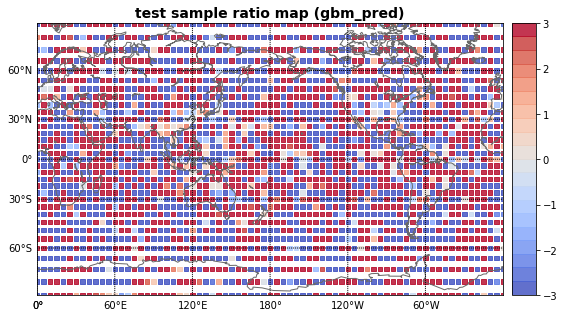

In [37]:
# build lat and lon dict to recode coord to 5dgx5dg boxes
# get lat and lon obs possible value
lat_keys = np.arange(-90., 90.1, 0.1)
lon_keys = np.arange(0., 360.1, 0.1)

# get new lat and lon possible values
lat_new = np.arange(-90, 90.1, 5.0)
lon_new = np.arange(0, 360.1, 5.0)

# for each possible values get the nearest among new values
lat_values = [sorted(lat_new, key=lambda x: abs(x - lat))[0] for lat in lat_keys]
lon_values = [sorted(lon_new, key=lambda x: abs(x - lon))[0] for lon in lon_keys]

# join keys and values into dict
lat_dict = dict(zip(np.round(lat_keys, 1), lat_values))
lon_dict = dict(zip(np.round(lon_keys, 1), lon_values))

# get data
X_test_unscaled = pd.DataFrame(X_scaler.inverse_transform(X_test), columns=cols)
df_ratio = pd.concat([X_test_unscaled[["LONGITUDE", "LATITUDE"]], ratio],
                     ignore_index=True, axis=1)

df_ratio.columns = ["lon", "lat", "ratio"]

# recode lon
mask_lon = df_ratio[df_ratio["lon"] < 0].index.tolist()
df_ratio.loc[mask_lon, "lon"] = df_ratio.loc[mask_lon, "lon"] + 360

# recode coord
df_ratio["new_lat"] = df_ratio.lat.map(lambda x: lat_dict[np.round(x, 1)])
df_ratio["new_lon"] = df_ratio.lon.map(lambda x: lon_dict[np.round(x, 1)])

# init colormap
cmap = plt.cm.get_cmap(name="coolwarm", lut=20)

# aggregate values with mean
means = df_ratio.groupby(["new_lon", "new_lat"])["ratio"].agg("mean").reset_index()

lats = means["new_lat"].values
lons = means["new_lon"].values
ratios = means["ratio"].values

# create a basemap object and project coord
proj = lmapping.Projection("mill", resolution="c", llcrnrlat=-80., urcrnrlat=80.)
bmap = lmapping.createMap(proj)
x, y = bmap(lons, lats)

# ready to plot now!
plt.figure(figsize=(10, 5))
plt.title("test sample ratio map (gbm_pred)",
          fontdict={"size": 14, "weight": "semibold"})

lmapping.drawMap(bmap, proj, fillcontinents=False)

sc = bmap.scatter(x, y, c=ratios, s=20, marker="s", cmap=cmap, alpha=0.8,
                  edgecolors="face", vmin=-3, vmax=3)

bmap.colorbar(sc, "right", size="5%", pad="2%")

plt.show()

In [38]:
print_ram_usage()

RAM usage: 49.73GB
